In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

nltk.download('wordnet')
nltk.download('punkt')

# Descargar stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gerb2\AppData\Roaming\nltk_data...
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gerb2\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gerb2\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [6]:
url = "https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv"
csv_path = tf.keras.utils.get_file("twitter_sentiment.csv", url)

3103165/3103165 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
df = pd.read_csv(csv_path)
df = df[['tweet', 'label']]
df.head()

,tweet,label
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0
3,#model i love u take with u all the time in ...,0
4,factsguide: society now #motivation,0


In [8]:
#-----------------------------------------------#
# # # 3. Funcion de depuracion de los datos # # #
#-----------------------------------------------#
# Funcion de pre-procesamiento de texto
def preprocesar_texto(texto, stop = True, lematizar = False, stemizar = False):
  '''
  INPUT:
    * texto : Conversacion que se desea depurar
    * stop :  Indicador de uso u omision de stopwords. Por default es True
    * lematizar : Indicador de uso u omision de lematizacion Por default es False
    * stemizar : Indicador de uso u omision de stemizacion Por default es False

  OUTPUT:
    * texto : Conversacion depurada
  '''
  # Convertir a minúsculas
  texto = texto.lower()

  # Eliminar caracteres especiales y números
  tabla_traduccion = str.maketrans('áéíóúñÁÉÍÓÚÑ', 'aeiounAEIOUN')
  texto = texto.translate(tabla_traduccion)
  texto = re.sub(r'[^a-z\s]', '', texto)

  # Quitando palabra user
  texto = re.sub(r'user', '', texto)

  # Eliminar stopwords
  if stop:
    palabras = texto.split()
    palabras = [palabra for palabra in palabras if palabra not in stop_words]
    texto = ' '.join(palabras)

  # Lematizar o stemizar (opcional)
  if lematizar:
      # Descarga el modelo de lematización si no está descargado
      lemmatizer = WordNetLemmatizer()
      palabras = texto.split()
      palabras = [lemmatizer.lemmatize(palabra) for palabra in palabras]
      texto = ' '.join(palabras)

  if stemizar:
      # Descarga el modelo de stemización si no está descargado
      stemmer = PorterStemmer()
      palabras = texto.split()
      palabras = [stemmer.stem(palabra) for palabra in palabras]
      texto = ' '.join(palabras)

  return texto

Estructura básica

In [9]:
# Revisar estructura básica
#0 = sentimiento negativo
#1= sentimiento positivo

print(df.info())
print(df['label'].value_counts())  # distribución de clases

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   31962 non-null  object
 1   label   31962 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 499.5+ KB
None
label
0    29720
1     2242
Name: count, dtype: int64


El modelo tiende a irse hacia sentimientos negativos. Para el desbalance podríamos:

Aplicar técnicas de resampling (oversampling/undersampling).
Usar técnicas como class weights en la función de pérdida de Keras.
Evaluar con métricas más robustas que accuracy (como F1-score).

In [10]:
# Longitud del texto (Número de caracteres en cada tweet)

df['text_len'] = df['tweet'].apply(len)
print(df['text_len'].describe())

count    31962.000000
mean        84.739628
std         29.455749
min         11.000000
25%         63.000000
50%         88.000000
75%        108.000000
max        274.000000
Name: text_len, dtype: float64


Es importante saber la longitud para saber que todas las secuencias tengan la misma longitud (rellenas las más cortas y cortas las largas)

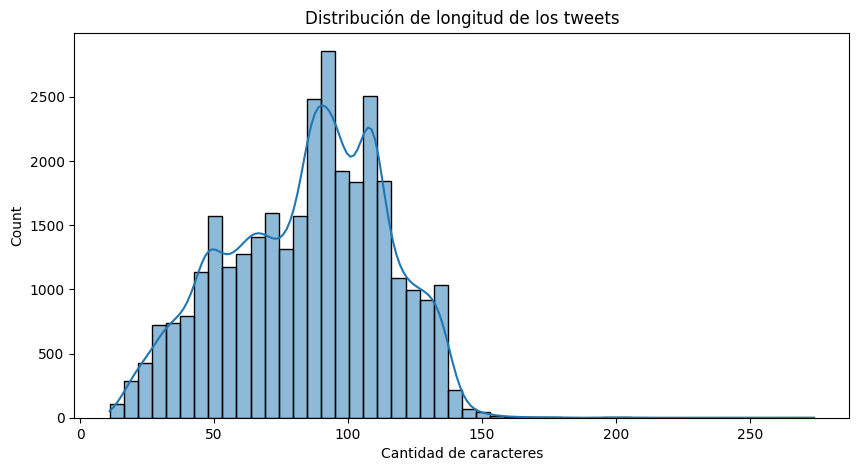

In [11]:
# Distribución de la longitud (cómo se comporta toda la población de tweets.)

plt.figure(figsize=(10,5))
sns.histplot(df['text_len'], bins=50, kde=True)
plt.title("Distribución de longitud de los tweets")
plt.xlabel("Cantidad de caracteres")
plt.show()

In [12]:
df['text_len'].quantile(0.95)

np.float64(130.0)

Hay tweets sospechosamente largos para ser reales

El 95% de los tweets tiene 130 palabras

el gráfico tiene una cola muy larga a la derecha, es señal de outliers largos

In [13]:
# Ver tweets con más de 130 palabras
df[df['text_len'] > 130].sample(5)

,tweet,label,text_len
11112,#mitb #mitbmatch is next so we could have a #c...,0,132
30326,when you make an offer on the house of your dr...,0,135
25931,"josephjett ""i do not advocate a kumbaya world....",1,132
13891,"obama, guns are bad, hate is bad, but still no...",0,132
861,"back to music""now playing michael jackson(the ...",0,137


In [14]:
# Tweets más cortos y más largos
print("Tweet más corto:\n", df.loc[df['text_len'].idxmin(), 'tweet'])
print("\nTweet más largo:\n", df.loc[df['text_len'].idxmax(), 'tweet'])

Tweet más corto:
 i love you 

Tweet más largo:
  @user lmfao pathetic #soit   #growup #funny #noonethere #iknowwhoitis ðððððððððððð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð±ð±ð¤ð¤ð±ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ð¤ðððððððâ¦


Muchos de los tweets largos tiene emojis mal codificados o caracteres especiales.

Los caracteres como ð son bytes mal decodificados en UTF-8, típicos cuando el archivo no se abre con la codificación correcta o los emojis no están normalizados.

In [15]:
# Ver duplicados
print("Duplicados:", df.duplicated(subset='tweet').sum())

Duplicados: 2432


Los tweets repetidos varias veces con la misma etiqueta pueden sobreajustar el modelo a patrones repetidos, como si fueran muy frecuentes.

Si hay un tweet con la misma frase pero distinta etiqueta, eso puede indicar un problema de calidad del dato.

También puede haber retweets duplicados que no aportan variedad semántica.

In [16]:
# Revisar nulos
print("Valores nulos:\n", df.isnull().sum())

Valores nulos:
 tweet       0
label       0
text_len    0
dtype: int64


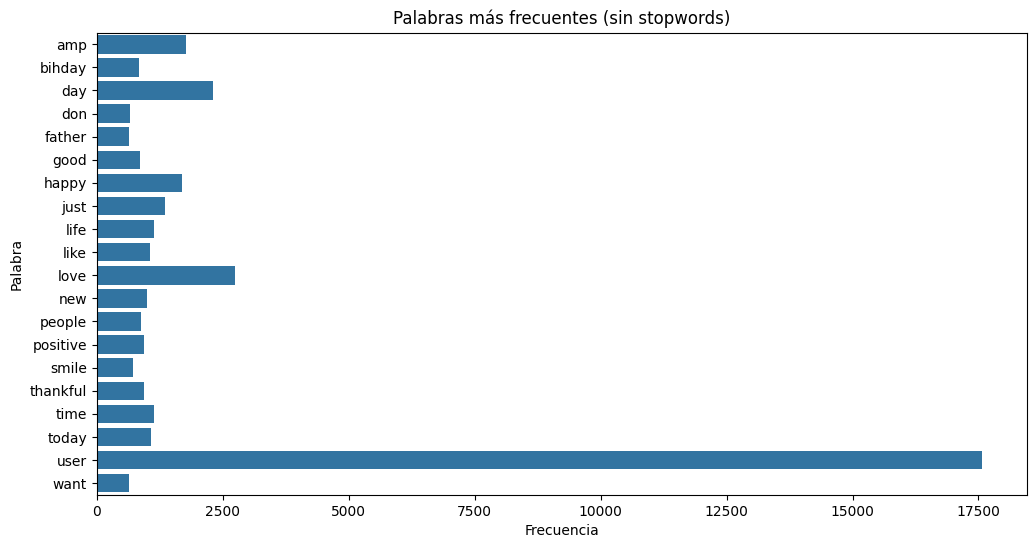

In [19]:
#Frecuencia de palabras

from sklearn.feature_extraction.text import CountVectorizer
#Usamos CountVectorizer para ver qué palabras son más comunes:

vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['tweet'])

# Mostrar palabras más comunes
words = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

# Visualizar
plt.figure(figsize=(12,6))
sns.barplot(x=counts, y=words)
plt.title("Palabras más frecuentes (sin stopwords)")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.show()

In [20]:
from collections import Counter

all_words = ' '.join(df['tweet']).split()
word_freq = Counter(all_words)

# Mostrar las 20 más comunes
print(word_freq.most_common(20))


[('@user', 17291), ('the', 10065), ('to', 9768), ('a', 6261), ('i', 5655), ('you', 4949), ('and', 4831), ('in', 4570), ('for', 4435), ('of', 4152), ('is', 4102), ('my', 3626), ('on', 2554), ('with', 2482), ('this', 2462), ('be', 2373), ('it', 2100), ('so', 1889), ('all', 1823), ('are', 1802)]


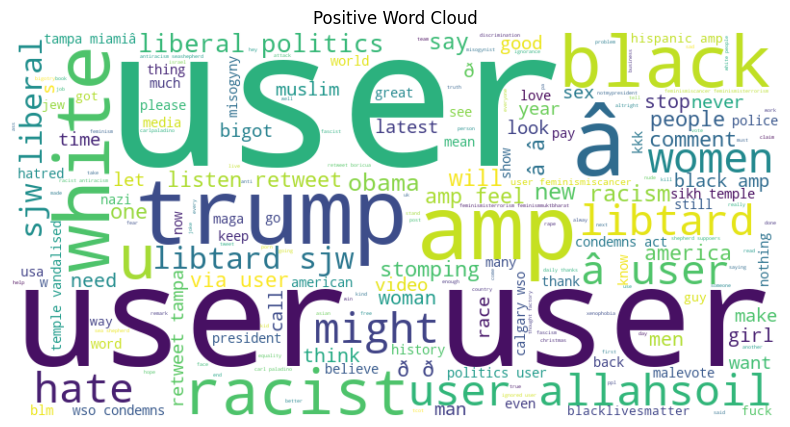

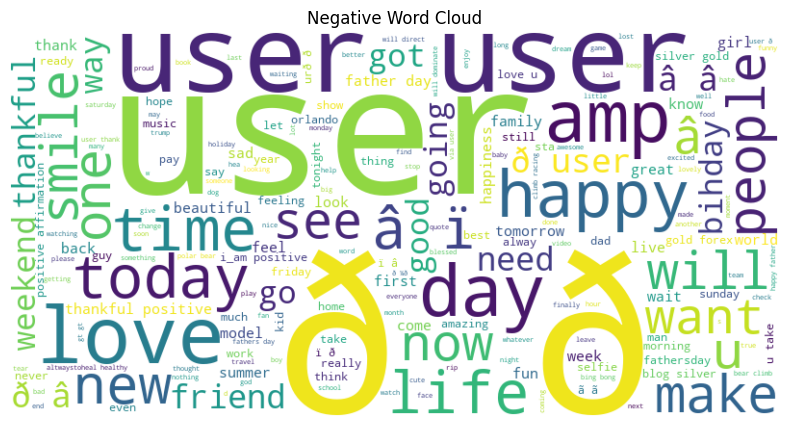

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Ensure 'label' column has the correct data type (e.g., string)
df['label'] = df['label'].astype(str)

positive_text = ' '.join(df[df['label'] == '1']['tweet']) # Filter by '1' for positive
negative_text = ' '.join(df[df['label'] == '0']['tweet']) # Filter by '0' for negative

# Generate and display the positive word cloud
plt.figure(figsize=(10, 5))
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(positive_text), interpolation='bilinear')
plt.title("Positive Word Cloud")
plt.axis("off")
plt.show()

# Generate and display the negative word cloud
plt.figure(figsize=(10, 5))
plt.imshow(WordCloud(width=800, height=400, background_color='white').generate(negative_text), interpolation='bilinear')
plt.title("Negative Word Cloud")
plt.axis("off")
plt.show()

Resumen de hallazgos:
Clases desbalanceadas : (0 hay 29720 y 1: hay 2242)
El minimo de longitud es 11 y el maximo es 271. El percentil 95 es 130 y el promedio es 85
La distribucion de longitud esta sesgada e la derecha indicando que hay outliers
la muestra de los tweets con longitud mayor a 130 muestra que hay muchos con caracteres como ððð
Tenemos 2432 Duplicados en la etiqueta de tweet y no tenemos nulos
la frecuencia de palabras indicó que la palabra que mas se repite es @user y luego palabras como the, to, a, i, you, and, ind, for, of.. etc.